# Assignment 2: Medical Image Classification

(c) Aleksei Tiulpin, PhD

In this assignment, you will learn how to replicate the architecture from Tiulpin et al. [1], and build your own neural net from scratch.

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-018-20132-7/MediaObjects/41598_2018_20132_Fig3_HTML.jpg" width="700px">


The goals of the assignment are:
1. To learn how to develop a Deep Learning pipeline for image classification in practice
2. Implement a neural network architecture
3. Build a robust setup for model evaluation


In [1], Tiulpin et al. use techniques like ensembling, but in this Assignment, we will work on a simplified version of it.


### References
[1] *Tiulpin, A., Thevenot, J., Rahtu, E., Lehenkari, P., & Saarakkala, S. (2018). Automatic knee osteoarthritis diagnosis from plain radiographs: a deep learning-based approach. Scientific reports, 8(1), 1727.*

## 1. Data loading (0.5 p)

Let us first mount the Google Drive.

In [1]:
# This will mount your google drive folder
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Before you can proceed, you need to make sure that you have access to the data within your Google Drive space. To get things right, you should create a shortcut to the folder you have been shared (folder named `Assignment_data_AI4Health`) to your drive.

By default, your directory is `/content`. Let us create it an unpack our data there.

Do this yourself.

In [ ]:
# %%time

# ###### YOUR CODE STARTS HERE (0.5p) #######
OUT_DIR = "/content/drive/MyDrive/Colab Notebooks/data_assignment2"
!tar -xzf "/content/drive/MyDrive/Colab Notebooks/kxr_loc_oai.tar.gz" -C "$OUT_DIR"
# ###### YOUR CODE ENDS HERE #########

Let us now verify that the contents of data folder are correct.

If you have done eveything right, you should see the following output:

In [ ]:
!ls /content/drive/MyDrive/Colab\ Notebooks/data_assignment2/kxr_loc_oai

00m  12m  24m  36m  48m


The data are structured as follows:
```
.
├── 00m
│   ├── 9000099_L_00839603_00m_045.png
│   ├── 9000099_R_00839603_00m_045.png
│   ├── ...
├── 12m
│   ├── ...
├── 24m
│   ├── ...
├── 36m
│   ├── ...
└── 48m
│   ├── ...
```
Every folder among `00m`, `12m`, `24m`, `36m`, `48m` stands for an OAI follow-up.

We used an incomplete OAI data to keep data from most of the subjects.

The filename format `9000099_R_00839603_00m_045.png` means that:
* The file belongs to subject with ID `9000099`
* It is the right knee
* The X-ray image has the barcode `00839603`
* The image is from `00m` follow-up
* The pixel spacing is `0.45mm`


Let us now look at the metadata. First we shall copy it from the shared folder to the local space:

In [ ]:
!cat /content/drive/MyDrive/Colab\ Notebooks/data_assignment2/metadata_oai.csv | head -n 4

ID,SIDE,VISIT,BARCODE,KL,JSM,OSTM,OSFM,JSL,OSTL,OSFL,FNAME
9000099,R,00m,00839603,2,0,1,0,0,1,2,00m/9000099_R_00839603_00m_045.png
9000099,L,00m,00839603,3,0,0,0,2,1,2,00m/9000099_L_00839603_00m_045.png
9000296,R,00m,00175004,2,1,1,0,0,0,0,00m/9000296_R_00175004_00m_045.png


What you can observe in the output above, is that there several groups of metadata:
* `ID`, `SIDE`, `VISIT` -- Self explanatory names
* `BARCODE` -- The barcode of an OAI image
* `KL` -- The KL grade
* `JSM`, `OSTM`, `OSFM` -- OARSI grades from the medial joint space width, tibial osteophyte, and femoral osteophyte
* `JSL`, `OSTL`, `OSFL` -- Similar to the above, but for the lateral side of the joint.
* `FNAME` -- The filename.

In our assignment, we will only use the patient-, the side-, the KL grade- and, the filename-related columns.

## 2. Imports

Let's get all necessary imports and dependencies sorted out.

In [4]:
!pip install solt

import torch
import pathlib
import random
import cv2
import gc
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import solt as sl
import solt.transforms as slt
import sklearn.model_selection as ms
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from torch import nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader


SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Fixing one of the most annoying "features" of opencv
cv2.ocl.setUseOpenCL(False)
cv2.setNumThreads(0)

## 3. Data split (0.5p)

Your first task is to figure out how to split the data. You should load the metadata file stored in `/content/data/metadata_oai.csv` and create a list of `5` splits where every element would contain pairs (train/val).

* Your target is KL grade.
* You have to make sure that your validation is correct.
* Do not forget to fix your random seed using variable `SEED`
* call the object `folds`

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data_assignment2/metadata_oai.csv")

In [ ]:
###### YOUR CODE STARTS HERE (0.5p) #######
from sklearn.model_selection import StratifiedGroupKFold

# create folds using StratifiedGroupKFold
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
folds = []

for fold_idx, (train_idx, val_idx) in enumerate(cv.split(df, df['KL'], groups=df['ID'])):
    train_split = df.iloc[train_idx].copy()
    val_split = df.iloc[val_idx].copy()
    # add fold id column
    train_split["fold"] = fold_idx
    val_split["fold"]   = fold_idx
    folds.append((train_split, val_split))

# checks the KL distribution for each fold
for i, (tr, va) in enumerate(folds):
    print(f"Fold {i}: Train {len(tr)}, Val {len(va)}")
    print("Val KL dist:\n", va['KL'].value_counts(normalize=True).sort_index())
###### YOUR CODE ENDS HERE #########

Fold 0: Train 21457, Val 5269
Val KL dist:
 KL
0    0.148605
1    0.149174
2    0.402164
3    0.224711
4    0.075346
Name: proportion, dtype: float64
Fold 1: Train 21383, Val 5343
Val KL dist:
 KL
0    0.149167
1    0.146173
2    0.420737
3    0.221411
4    0.062512
Name: proportion, dtype: float64
Fold 2: Train 21447, Val 5279
Val KL dist:
 KL
0    0.144914
1    0.161394
2    0.401970
3    0.233756
4    0.057966
Name: proportion, dtype: float64
Fold 3: Train 21299, Val 5427
Val KL dist:
 KL
0    0.157730
1    0.159388
2    0.406302
3    0.206744
4    0.069836
Name: proportion, dtype: float64
Fold 4: Train 21318, Val 5408
Val KL dist:
 KL
0    0.142936
1    0.179179
2    0.392382
3    0.224852
4    0.060651
Name: proportion, dtype: float64


In [ ]:
total_samples = 0
for train_split, val_split in folds:
    assert ~train_split.ID.isin(val_split.ID).any()
    total_samples += val_split.shape[0]

assert total_samples == df.shape[0]

## 4. Data augmentation and patches (1.5p)

Let us now load a few images for 1 subject before we start working on data loading and augmentation



In [ ]:
df.iloc[0:2]

,ID,SIDE,VISIT,BARCODE,KL,JSM,OSTM,OSFM,JSL,OSTL,OSFL,FNAME
0,9000099,R,00m,839603,2,0,1,0,0,1,2,00m/9000099_R_00839603_00m_045.png
1,9000099,L,00m,839603,3,0,0,0,2,1,2,00m/9000099_L_00839603_00m_045.png


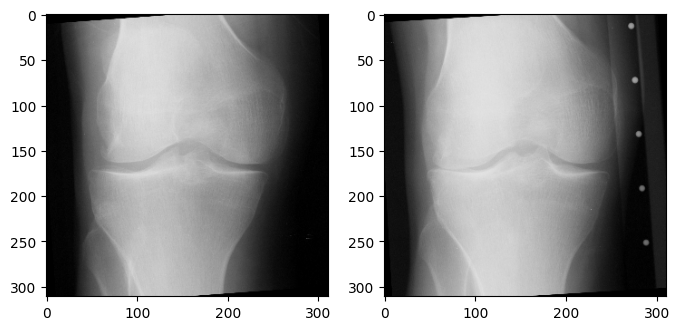

In [ ]:
# base_dir = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/data_assignment2/kxr_loc_oai")
base_dir = pathlib.Path("/content/kxr_loc_oai")
plt.figure(figsize=(8, 5))
for j, (_, entry) in enumerate(df.iloc[0:2].iterrows()):
    img = cv2.imread(base_dir / entry.FNAME)
    plt.subplot(1, 2, j+1)
    plt.imshow(img)
plt.show()

You can make two key observations here:
* The original images had the size of `140x140mm`, but they were rotated to prepocess
* The left images were flipped to look like the right one

Keep this in mind.

Let us now work on a solt pipeline to replicate the augmentations from [1]. Below is the exact list of transformations from the paper:


1. Random brightness shift (±30%)
2. Random contrast shift (±30%)
3. Random rotate (±15°)
4. Random gamma correction (-50% to 250%)
5. A 130x130mm crop shifted randomly between 6 and 20 pixels (can be replaced by a random crop)

Let us implement this pipeline using `SOLT`: https://oulu-imeds.github.io/solt/

The starting point for this, is to create a solt.Stream object, and populate it with the augmentations from the list. Few things to note:

1.  Random brightness shift in solt takes actual numerical range of brightness shift, not percentages. Keep in mind that the PNGs are 8bit. This is a legacy behavior that will be removed in the upcoming release.
2. Random contrast takes the percentages.
3. All augmentations in the paper had `p=1`


Finally, here is a direct quote from the paper:


> First, we re-scaled the `130x130mm` regions to a size of `300x300` pixels and then cropped two squared patches `SxS` pixels with the vertical offset of `K` pixels


You should be cropping from a given resolution to `130x130mm` region. This is `289x289` pixels. You should resize your image at the end to `300x300` pixels to generate the patches as shown in the paper.


Replicate the augemntations as described in the list above. Create also set of transformations for the validation test.

As a result you should have two SOLT stream objects -- `train_aug` and `val_aug`.


In [ ]:
###### YOUR CODE STARTS HERE (1p) #######
train_aug = sl.Stream([
    # Random brightness shift (30%)
    # Le immagini PNG sono 8-bit, quindi range [0, 255]
    # 30% di 255 = 76.5
    slt.Brightness(p=1.0, brightness_range=(-0.3 * 255, 0.3 * 255)),

    # Random contrast shift (30%)
    # slt.Contrast(p=1.0, contrast_range=(1.0-0.3, 1.0+0.3)),
    slt.Contrast(p=1.0, contrast_range=0.3), # same as above

    # Random rotation between -15 and 15 degrees
    slt.Rotate(angle_range=15.0, p=1.0),

    # Random gamma correction between -50% and 250%
    slt.GammaCorrection(p=1.0, gamma_range=(0.5, 2.5)),

    # random crop da 140x140mm (310x310 pixels) a 130x130mm (289x289 pixels)
    slt.Crop(crop_to=(289, 289), crop_mode='r'),

    # Resize finale a 300x300 pixels come descritto nel paper
    slt.Resize(resize_to=(300, 300))
])

# Solo center-crop a 289 e resize a 300, nessuna alterazione fotometrica/geometrica casuale
val_aug = sl.Stream([
    slt.Crop(crop_to=(289, 289), crop_mode='c'),
    slt.Resize(resize_to=(300, 300))
])
###### YOUR CODE ENDS HERE #########

We can now run the augementation only one one image to see that we are doing the right thing:

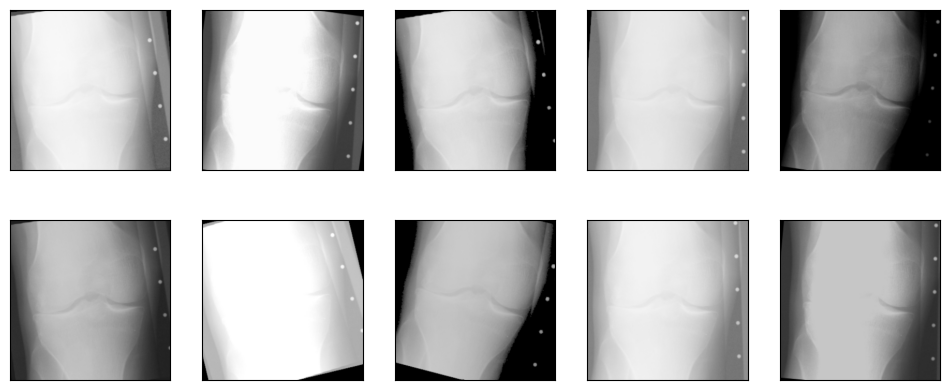

In [ ]:
n_runs = 5
plt.figure(figsize=(12, 5))
for i in range(n_runs):
    plt.subplot(2, n_runs, i*2 + 1)
    img = cv2.imread(base_dir / df.iloc[1].FNAME)
    img_trf = train_aug(img, normalize=False, return_torch=False).data[0]
    plt.imshow(img_trf)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, n_runs, i*2 + 2)
    img = cv2.imread(base_dir / df.iloc[1].FNAME)
    img_trf = train_aug(img, normalize=False, return_torch=False).data[0]
    plt.imshow(img_trf)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
assert train_aug(img, normalize=False, return_torch=False).data[0].shape == (300, 300, 3)
assert val_aug(img, normalize=False, return_torch=False).data[0].shape == (300, 300, 3)

In [ ]:
train_aug(img, normalize=False, return_torch=False).data[0].shape

(300, 300, 3)

The final step is to make sure we can generate the patches for the siamese model. For this, Tiulpin et al used the following strategy:

1. Set vertical offset `K=100` pixels
2. Set the patch size to `S=128` pixels (patches are `SxS` pixels). Crop a patches of size `SxS` with a vertical offset of `K` pixels from the medial and the lateral side.
4. They flipped the medial patches to make sure that the lateral and the medial sides look similar for the siamese network.

Let's implement the cropping:

In [ ]:
def crop_patches(img, s, k):
    ###### YOUR CODE STARTS HERE (0.5p) #######
    # Crop lateral patch from left side: y from k to k+s, x from 0 to s
    l = img[k:k+s, 0:s, :]
    # Crop medial patch from right side: y from k to k+s, x from -s to end
    m = img[k:k+s, -s:, :]
    # Flip medial patch horizontally to match lateral orientation
    m = np.flip(m, axis=1)
    m = m.copy()  # to avoid issues with negative strides

    return l, m
    ###### YOUR CODE ENDS HERE #########

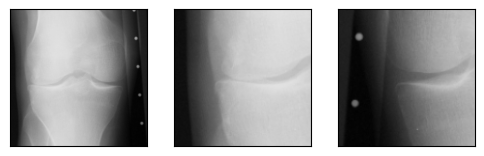

In [ ]:
img_300 = val_aug(img, normalize=False, return_torch=False).data[0]

l, m = crop_patches(img_300, 128, 100)

plt.figure(figsize=(6, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_300)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.imshow(l)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.imshow(m)
plt.xticks([])
plt.yticks([])
plt.show()

You can now check that everything works by (a) augmenting the images and (b) generating the patches in a loop.

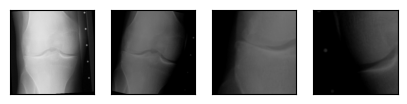

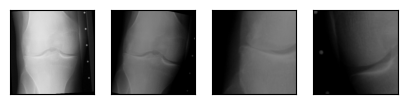

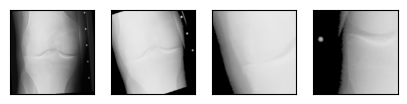

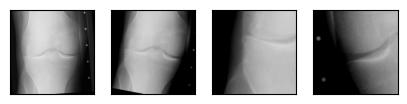

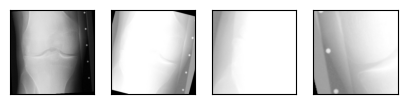

In [ ]:
for i in range(5):
    img = cv2.imread(base_dir / df.iloc[1].FNAME)
    img_trf = train_aug(img, normalize=False, return_torch=False).data[0]
    l, m = crop_patches(img_trf, 128, 100)

    plt.figure(figsize=(5, 3))
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 2)
    plt.imshow(img_trf)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 3)
    plt.imshow(l)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 4)
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.show()

Let us know design the PyTorch Dataset. Keep in mind that you need to slightly change your cropping function to make sure that it works correctly with torch tensors (numpy: chanel last, torch: channel first notation).

## 5. The dataset class (2.5p)

Let us now implement the dataset class. Here, we will combine the data augmentation with patch cropping. As a result, your dataset must return a dictionary with the following entries:

1. `img_l`: cropped lateral patch (`torch.FloatTensor`)
2. `img_m`: cropped and **flipped** lateral patch (`torch.FloatTensor`)
3. `target`: the KL grade.


In [ ]:
class KneeGraderDataset(Dataset):
    def __init__(self, base_dir, ds: pd.DataFrame, augs: sl.Stream, s=128, k=100):
        ###### YOUR CODE STARTS HERE (1p) #######
        self.base_dir = base_dir
        self.dataset = ds
        self.trf = augs
        self.s = s
        self.k = k
        ###### YOUR CODE ENDS HERE #########

    def __getitem__(self, idx):
        ###### YOUR CODE STARTS HERE (1p) #######
        entry = self.dataset.iloc[idx]

        img = cv2.imread(str(self.base_dir / entry.FNAME))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # apply augs if available
        if self.trf is not None:
            container = self.trf(img, normalize=True, return_torch=True) # CHW torch.FloatTensor in [0,1]
            chw = container["image"]
            hwc = chw.permute(1, 2, 0).contiguous().cpu().numpy() # HWC float32
        else:
            hwc = (img.astype(np.float32) / 255.0)

        # crop patches (expects HWC numpy). crop_patches already flips medial.
        l, m = crop_patches(hwc, self.s, self.k)

        # back to CHW torch tensors
        l_tensor = torch.tensor(l).permute(2, 0, 1)
        m_tensor = torch.tensor(m).permute(2, 0, 1)

        return {
            'img_l': l_tensor,
            'img_m': m_tensor,
            'target': torch.tensor(entry.KL, dtype=torch.long)
        }
        ###### YOUR CODE ENDS HERE #########

    def __len__(self):
        ###### YOUR CODE STARTS HERE (0.5p) #######
        return self.dataset.shape[0]
        ###### YOUR CODE ENDS HERE #########

In [ ]:
# choose a fold index, e.g. 0
fold_idx = 0

# unpack the corresponding (train_df, val_df) from your folds list
train_df, val_df = folds[fold_idx]

In [ ]:
ds = KneeGraderDataset(base_dir, train_df, train_aug, 128, 100)

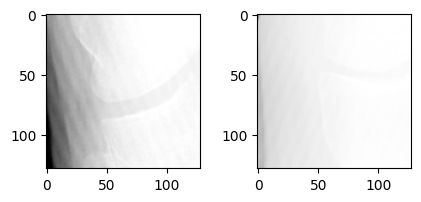

In [ ]:
res = ds[0]
plt.figure(figsize=(5, 2))
plt.subplot(1, 2, 1)
plt.imshow(res["img_l"][0, :, :], cmap=plt.cm.Greys_r)
plt.subplot(1, 2, 2)
plt.imshow(res["img_m"][0, :, :], cmap=plt.cm.Greys_r)
plt.show()

## 6. The model (4p)

Now we can work on the model. Tiulpin et al. use the Siamese model, where they share the weights for the patches.

Read the paper for more details. Please pay close difference to the difference between a regualar siamese model and the one by Tiulpin et al.:

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-018-20132-7/MediaObjects/41598_2018_20132_Fig2_HTML.jpg">

In subfigure (a) you can see a Siamese network's implementation for metric learning and in subfigure (b), you can see the implementation by Tiulpin et al.

In [6]:
def weights_init_uniform(m):
    """
    Initializes the weights using kaiming method.
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        m.bias.data.fill_(0)

class KneeNet(nn.Module):
    """
    Siamese Net to grade osteoarthritis
    """
    def __init__(self, bw, drop):
        super().__init__()
        ###### YOUR CODE STARTS HERE (3p) #######
        #  N, 3x3, stride=2
        self.backbone1 = nn.Sequential(
            nn.Conv2d(3, bw, kernel_size=(3, 3), stride=2),
            nn.BatchNorm2d(bw),
            nn.ReLU()
        )

        # N, 3x3, stride=1
        self.backbone2 = nn.Sequential(
            nn.Conv2d(bw, bw, kernel_size=(3, 3), stride=1),
            nn.BatchNorm2d(bw),
            nn.ReLU()
        )

        # N, 3x3, stride=1
        self.backbone3 = nn.Sequential(
            nn.Conv2d(bw, bw, kernel_size=(3, 3), stride=1),
            nn.BatchNorm2d(bw),
            nn.ReLU()
        )

        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        # 2N, 3x3, stride=1
        self.backbone4 = nn.Sequential(
            nn.Conv2d(bw, 2*bw, kernel_size=(3, 3), stride=1),
            nn.BatchNorm2d(2*bw),
            nn.ReLU()
        )

        # 2N, 3x3, stride=1
        self.backbone5 = nn.Sequential(
            nn.Conv2d(2*bw, 2*bw, kernel_size=(3, 3), stride=1),
            nn.BatchNorm2d(2*bw),
            nn.ReLU()
        )

        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        # 4N, 3x3, stride=1 + GAP
        self.backbone6 = nn.Sequential(
            nn.Conv2d(2*bw, 4*bw, kernel_size=(3, 3), stride=1),
            nn.BatchNorm2d(4*bw),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.dropout = nn.Dropout(p=drop)
        self.fc = nn.Linear(in_features=8*bw, out_features=5)
        ###### YOUR CODE ENDS HERE #########

        # The unform weight initialization is an important trick
        # Here we help you out with it
        self.apply(weights_init_uniform)


    def forward(self, x1, x2):
        ###### YOUR CODE STARTS HERE (1p) #######
        x1_1 = self.backbone1(x1)
        x1_2 = self.backbone2(x1_1)
        x1_3 = self.backbone3(x1_2)
        x1_pool1 = self.pool1(x1_3)
        x1_4 = self.backbone4(x1_pool1)
        x1_5 = self.backbone5(x1_4)
        x1_pool2 = self.pool2(x1_5)
        x1_6 = self.backbone6(x1_pool2)

        x2_1 = self.backbone1(x2)
        x2_2 = self.backbone2(x2_1)
        x2_3 = self.backbone3(x2_2)
        x2_pool1 = self.pool1(x2_3)
        x2_4 = self.backbone4(x2_pool1)
        x2_5 = self.backbone5(x2_4)
        x2_pool2 = self.pool2(x2_5)
        x2_6 = self.backbone6(x2_pool2)

        # concatenate the outputs
        x = torch.cat((x1_6, x2_6), dim=1)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        logits = self.fc(x)

        return logits
        ###### YOUR CODE ENDS HERE #########

In [ ]:
model = KneeNet(16, 0.2)
model.eval()
with torch.no_grad():
    out = model(res["img_l"].unsqueeze(0), res["img_m"].unsqueeze(0))

assert out.size() == torch.Size([1, 5])

## 7. Training code (2p)

Here we can just follow the template from Lecture 9.

Your task here would be to implement the model selection step, and store the checkpoint for the best model. The following is the logic that you need to implement:

1. After every epoch, you should check whether there is an improvement in terms of Kappa or BACC (selection metric is set via config, and can be accessed through `self.cfg.select_metric`)
2. If there is an improvement, store the snapshot, and store the predictions.
3. Snapshot name must have the following format: `fold_<FOLD>_epoch_<EPOCH>_seed_<SEED>_<METRIC NAME><SCORE>.pth`.

In the score, you should replace the `.` by double underscore `__`.

There are a few other pieces in the code that you should fill:

1. `pass_batch` method
2. `init_run` method

In [ ]:
class Trainer:
    def __init__(self, train_df, val_df, cfg):
        self.train_df = train_df
        self.val_df = val_df

        # A good style is to define variables before we use them
        # If nothing is stored, we just store `None`.
        self.train_loader = None
        self.val_loader = None
        self.loss_fn = None
        self.optimizer = None
        self.model = None
        # Data loader params
        self.cfg = cfg

    def init_model(self):
        if hasattr(self, "model"):
            del self.model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

        model = KneeNet(self.cfg.bw, self.cfg.dropout)
        self.model = model.to(self.cfg.device)

    def init_run(self):
        del self.train_loader
        del self.val_loader
        del self.optimizer

        gc.collect()
        torch.cuda.empty_cache()

        self.init_model()

        ###### YOUR CODE STARTS HERE (0.5p) #######
        train_ds = KneeGraderDataset(
            base_dir=pathlib.Path(self.cfg.base_dir),
            ds=self.train_df,
            augs=train_aug,
            s=self.cfg.s,
            k=self.cfg.k
        )
        val_ds = KneeGraderDataset(
            base_dir=pathlib.Path(self.cfg.base_dir),
            ds=self.val_df,
            augs=val_aug,
            s=self.cfg.s,
            k=self.cfg.k
        )
        ###### YOUR CODE ENDS HERE #########
        self.train_loader = DataLoader(train_ds, batch_size=self.cfg.batch_size, shuffle=True, num_workers=self.cfg.n_workers)
        # It is often useful to use sequential sampler for the validation set loader, but it may slow things down.
        # to use such sampling policy, specify the sampler argument sampler=SequentialSampler(self.val_ds)
        self.val_loader = DataLoader(val_ds, batch_size=self.cfg.batch_size, num_workers=self.cfg.n_workers)

        # Setting up a model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.wd)
        # Setting up the loss
        # We again use object-oriented design for the configs
        if self.cfg.loss == 'ce':
            self.loss_fn = torch.nn.CrossEntropyLoss()
        else:
            err = f"Loss function with code {self.cfg.loss} is not implemented"
            raise NotImplementedError(err)

    def run(self, n_epochs=None):
        self.init_run()
        if n_epochs is None:
            n_epochs = self.cfg.num_epochs
        for self.epoch in range(n_epochs):
            # Here, we set the model to train
            # This enables learning of the BatchNorm statistics and
            # enables the dropout
            self.model.train()
            train_loss = self.train_epoch()

            # Eval mode is contrary to the train
            # It sets the dropout off and uses already learned
            # BatchNorm stats
            self.model.eval()
            val_loss, val_bacc, val_kappa, preds_val, gt_val = self.val_epoch()

            ###### YOUR CODE STARTS HERE (1p) #######
            metric_name = self.cfg.select_metric  # "kappa" o "bacc"
            metric_val = val_kappa if metric_name == "kappa" else val_bacc
            if metric_val > self.cfg.best_metric:
                self.cfg.best_metric = metric_val
                self.cfg.checkpoint_path.mkdir(parents=True, exist_ok=True)
                sc = f"{metric_val:.4f}".replace(".", "__")
                snap = f"fold_{self.train_df['fold'].unique()[0]}_epoch_{self.epoch}_seed_{SEED}_{metric_name}{sc}.pth"
                torch.save({
                        "model": self.model.state_dict(),
                        "cfg": vars(self.cfg),
                        "epoch": self.epoch,
                        "metric": metric_val,
                        "preds": preds_val, "gt": gt_val
                    },
                    self.cfg.checkpoint_path / snap
            )
            ###### YOUR CODE ENDS HERE #########

            sys.stderr.flush()
            print("="*50)
            print(f"[{self.epoch}] --> Kappa :{val_kappa:.4f}")
            print(f"[{self.epoch}] --> BACC :{val_bacc:.4f}")
            print(f"[{self.epoch}] --> Train loss :{train_loss:.4f}")
            print(f"[{self.epoch}] --> Val loss :{val_loss:.4f}")
            print("="*50)

    def pass_batch(self, batch):
 

    def train_epoch(self):
        sys.stderr.flush()
        pbar = tqdm(total=len(self.train_loader), position=0, leave=True)

        running_loss = torch.tensor(0., requires_grad=False).to(self.cfg.device)

        # Lecture 9 had a bug in Learning rate scheduling
        # Here is a fix.
        if self.epoch in self.cfg.lr_drop_milestones:
            for param_group in self.optimizer.param_groups:
                param_group["lr"] *= 0.1

        for i, batch in enumerate(self.train_loader):
            self.optimizer.zero_grad()
            loss, _ = self.pass_batch(batch)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            cur_loss = running_loss.item() / (i + 1)

            desc = f'[{self.epoch}] Train {loss.item():.4f} / {cur_loss:.4f}'
            pbar.set_description(desc)
            pbar.update()

        pbar.close()
        running_loss = running_loss.div_(len(self.train_loader))

        return running_loss.item()

    def val_epoch(self):
        preds = []
        gt = []
        sys.stderr.flush()
        running_loss = torch.tensor(0., requires_grad=False).to(self.cfg.device)
        with torch.no_grad():
            pbar = tqdm(total=len(self.val_loader), desc=f"[{self.epoch}] Validation....", position=0, leave=True)
            for i, batch in enumerate(self.val_loader):
                loss, output = self.pass_batch(batch)

                # Underscore operations mean modification in-place
                running_loss.add_(loss)

                preds.append(output.cpu())
                gt.append(batch['target'])
                pbar.update()
            preds = torch.cat(preds)
            gt = torch.cat(gt)
            pbar.close()

        # Recall that these are LOGITS
        preds = preds.numpy()
        gt = gt.numpy()

        bacc = balanced_accuracy_score(gt, preds.argmax(1))
        kappa = cohen_kappa_score(gt, preds.argmax(1), weights='quadratic')
        running_loss.div_(len(self.val_loader))

        return running_loss.item(), bacc, kappa, preds, gt

Complete the config below and add the missing augmentations.

In [14]:
class Cfg:
    # base_dir = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/data_assignment2/kxr_loc_oai")
    base_dir = pathlib.Path("/content/kxr_loc_oai")

    device = torch.device("cuda:0")
    s = 128
    k = 100

    wd = 1e-4
    lr = 1e-3

    num_epochs = 50
    n_workers = 2
    batch_size = 64
    lr_drop_milestones = [10000, ] # We set this to 10000, as we do not need to drop the learnig rate.

    bw = 64
    dropout = 0.2

    loss = 'ce'

    ###### YOUR CODE STARTS HERE (0.5p) #######
    select_metric = "kappa" # or "bacc"
    best_metric = float("-inf")
    checkpoint_path = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/data_assignment2/checkpoints")
    ###### YOUR CODE ENDS HERE #########

We now need to train the code for 20-40 epochs to get kappa above 0.8 and BACC above 0.7.

In this assignment, we do not need to train extensively. If your code works, within 30 minutes, you should be getting a very good model.

**Note:** It is sufficient to get the code working on fold 1 to save compute. You can also use only fold 1 to get the rest of the points in the eval section.

In [ ]:
cfg_2 = Cfg()
cfg_2.checkpoint_path = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/data_assignment2/checkpoints_siamese_2")
for train_df, val_df in folds:
    trainer_2 = Trainer(train_df, val_df, cfg_2)
    trainer_2.run(30)
    break

[0] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.45it/s]


[0] --> Kappa :0.3333
[0] --> BACC :0.3315
[0] --> Train loss :1.4442
[0] --> Val loss :1.2100


[1] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.48it/s]


[1] --> Kappa :0.6251
[1] --> BACC :0.4586
[1] --> Train loss :1.1686
[1] --> Val loss :1.1604


[2] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.59it/s]


[2] --> Kappa :0.6307
[2] --> BACC :0.5111
[2] --> Train loss :1.0912
[2] --> Val loss :1.0113


[3] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.77it/s]


[3] --> Kappa :0.5892
[3] --> BACC :0.5009
[3] --> Train loss :1.0408
[3] --> Val loss :0.9149


[4] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.73it/s]


[4] --> Kappa :0.6659
[4] --> BACC :0.4663
[4] --> Train loss :1.0052
[4] --> Val loss :1.0090


[5] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.50it/s]


[5] --> Kappa :0.7067
[5] --> BACC :0.5569
[5] --> Train loss :0.9743
[5] --> Val loss :0.8592


[6] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.88it/s]


[6] --> Kappa :0.7325
[6] --> BACC :0.5919
[6] --> Train loss :0.9467
[6] --> Val loss :0.8756


[7] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.71it/s]


[7] --> Kappa :0.7328
[7] --> BACC :0.5745
[7] --> Train loss :0.9245
[7] --> Val loss :0.8379


[8] Validation....: 100%|██████████| 83/83 [00:09<00:00,  9.02it/s]


[8] --> Kappa :0.7540
[8] --> BACC :0.6206
[8] --> Train loss :0.9065
[8] --> Val loss :0.8033


[9] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.63it/s]


[9] --> Kappa :0.7310
[9] --> BACC :0.6061
[9] --> Train loss :0.8931
[9] --> Val loss :0.8338


[10] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.90it/s]


[10] --> Kappa :0.7507
[10] --> BACC :0.5687
[10] --> Train loss :0.8758
[10] --> Val loss :0.8290


[11] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.87it/s]


[11] --> Kappa :0.7486
[11] --> BACC :0.6132
[11] --> Train loss :0.8624
[11] --> Val loss :0.7817


[12] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.76it/s]


[12] --> Kappa :0.7785
[12] --> BACC :0.6142
[12] --> Train loss :0.8500
[12] --> Val loss :0.8644


[13] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.77it/s]


[13] --> Kappa :0.7947
[13] --> BACC :0.6384
[13] --> Train loss :0.8393
[13] --> Val loss :0.8108


[14] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.95it/s]


[14] --> Kappa :0.7757
[14] --> BACC :0.6035
[14] --> Train loss :0.8422
[14] --> Val loss :0.8128


[15] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.73it/s]


[15] --> Kappa :0.7339
[15] --> BACC :0.5688
[15] --> Train loss :0.8203
[15] --> Val loss :0.8202


[16] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.93it/s]


[16] --> Kappa :0.7032
[16] --> BACC :0.5909
[16] --> Train loss :0.8141
[16] --> Val loss :0.8910


[17] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.96it/s]


[17] --> Kappa :0.7982
[17] --> BACC :0.6746
[17] --> Train loss :0.8094
[17] --> Val loss :0.8291


[18] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.68it/s]


[18] --> Kappa :0.7906
[18] --> BACC :0.6562
[18] --> Train loss :0.8025
[18] --> Val loss :0.7913


[19] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.55it/s]


[19] --> Kappa :0.8090
[19] --> BACC :0.6848
[19] --> Train loss :0.7932
[19] --> Val loss :0.7373


[20] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.71it/s]


[20] --> Kappa :0.7363
[20] --> BACC :0.5367
[20] --> Train loss :0.7830
[20] --> Val loss :0.8841


[21] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.58it/s]


[21] --> Kappa :0.7969
[21] --> BACC :0.6567
[21] --> Train loss :0.7766
[21] --> Val loss :0.7900


[22] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.90it/s]


[22] --> Kappa :0.8082
[22] --> BACC :0.6827
[22] --> Train loss :0.7667
[22] --> Val loss :0.7414


[23] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.68it/s]


[23] --> Kappa :0.7909
[23] --> BACC :0.6578
[23] --> Train loss :0.7660
[23] --> Val loss :0.8007


[24] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.67it/s]


[24] --> Kappa :0.7925
[24] --> BACC :0.6282
[24] --> Train loss :0.7576
[24] --> Val loss :0.7624


[25] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.85it/s]


[25] --> Kappa :0.7769
[25] --> BACC :0.6331
[25] --> Train loss :0.7586
[25] --> Val loss :0.7762


[26] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.54it/s]


[26] --> Kappa :0.8072
[26] --> BACC :0.6726
[26] --> Train loss :0.7442
[26] --> Val loss :0.7435


[27] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.93it/s]


[27] --> Kappa :0.7488
[27] --> BACC :0.5943
[27] --> Train loss :0.7403
[27] --> Val loss :0.7859


[28] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.77it/s]


[28] --> Kappa :0.7869
[28] --> BACC :0.6374
[28] --> Train loss :0.7291
[28] --> Val loss :0.7694


[29] Validation....: 100%|██████████| 83/83 [00:09<00:00,  8.44it/s]


[29] --> Kappa :0.7928
[29] --> BACC :0.6614
[29] --> Train loss :0.7342
[29] --> Val loss :0.8246


## Statistical evaluation & analysis (9 points)

Now, when the basic trainer is implemented and the code seems to work, you need to make further improvements. Here, you need to do an independent study to gain the remaining points and train the same pipeline as above, but utilize another network, from pytorch pretrained model zoo. After you have trained this model, compare it to the siamese model using permutation test and compute the confidence intervals.

**To be specific, this is what you need to do:**

1. Make sure that the seed for fold splitting is the same.
2. Use ResNet18 from the PyTorch pretrained model zoo. Adapt the model’s output layer to match the classification task.
3. Make sure you use ImageNet weights: https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
3. Use the same training pipeline we have developed for the Siamese model (same preprocessing, training loop, optimizer, etc.).
4. Using the validation set predictions from both types of models: Resnet18 and th Siamese model by Tiulpin et al., run a permutation test on Kappa and The Balanced Accuracy. What conclusions do you get? What can you tell about the perfromance of the Siamese model?

**Points distribution**
1. **[2 points]:** You have trained ResNet18 to convergence. The results should be about the same as in the Siamese model, but they tend to be lower. Kappa should certainly be about 0.80
2. **[1 points]:** You have  used bootstrap to compute confidence intervals
3. **[0.5 points]:** You have used bootstrap test to compute the p-value correctly.
4. **[4 points]** You have done your research and corrected the bootstrap procedure so that it accounts for non-i.i.d. structure of the data. You need to search for cluster bootstrap. The general idea of the cluster bootstrap, is to fix the bias that comes from multiple data coming from the same patient. What we do is: (1) resample patient with replacements, (2) concatenate data for the resampled patients into an array, (3) do bootstrap.
5. **[1.5 points]** You have correctly explained why the Siamese model worked so well compared to the resnet one, and you have correctly explained why we should have changed the bootstrap procedure.



## ResNet18

In [ ]:
class SingleKneeDataset(Dataset):
    def __init__(self, base_dir, ds, transform=None):
        self.base_dir = base_dir  # pathlib.Path da cfg
        self.dataset = ds  # pd.DataFrame da train_df/val_df
        self.trf = transform  # solt.Stream o None

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        entry = self.dataset.iloc[idx]
        img_path = self.base_dir / entry['FNAME']
        img = cv2.imread(img_path)  # [H,W,3] uint8, grayscale?Statistical evaluation & analysis → BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # To RGB [H,W,3]

        if self.trf is not None:
            # Apply SOLT transformations
            container = self.trf(img, normalize=True, return_torch=True) # CHW torch.FloatTensor in [0,1]
            img = container['image'] # solt.Stream with normalize=True returns torch tensor [C,H,W] float32
        else:
            # Basic processing if no SOLT stream
            img = img.astype(np.float32) / 255.0
            img = torch.from_numpy(img).permute(2, 0, 1)  # [C,H,W] float32

        return {
            'img': img,
            'target': torch.tensor(int(entry.KL), dtype=torch.long)
        }

In [ ]:
import timm

class Trainer_timm:
    def __init__(self, train_df, val_df, cfg):
        self.train_df = train_df
        self.val_df = val_df
        self.train_loader = None
        self.val_loader = None
        self.loss_fn = None
        self.optimizer = None
        self.model = None
        self.cfg = cfg

    def init_model(self):
        if hasattr(self, "model"):
            del self.model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

        m = timm.create_model("resnet18", pretrained=True, num_classes=5)
        m.fc = torch.nn.Sequential(
            torch.nn.Dropout(p=self.cfg.dropout),
            m.fc
        )
        self.model = m.to(self.cfg.device)

    def init_run(self):
        del self.train_loader
        del self.val_loader
        del self.optimizer

        gc.collect()
        torch.cuda.empty_cache()

        self.init_model()

        train_ds = SingleKneeDataset(
            base_dir=pathlib.Path(self.cfg.base_dir),
            ds=self.train_df,
            transform=train_aug
        )
        val_ds = SingleKneeDataset(
            base_dir=pathlib.Path(self.cfg.base_dir),
            ds=self.val_df,
            transform=val_aug
        )

        self.train_loader = DataLoader(train_ds, batch_size=self.cfg.batch_size, shuffle=True, num_workers=self.cfg.n_workers)
        self.val_loader = DataLoader(val_ds, batch_size=self.cfg.batch_size, num_workers=self.cfg.n_workers)
        # Setting up a model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.wd)
        # Setting up the loss
        if self.cfg.loss == 'ce':
            self.loss_fn = torch.nn.CrossEntropyLoss()
        else:
            err = f"Loss function with code {self.cfg.loss} is not implemented"
            raise NotImplementedError(err)

    def run(self, n_epochs=None):
        self.init_run()

        if n_epochs is None:
            n_epochs = self.cfg.num_epochs
        for self.epoch in range(n_epochs):
            self.model.train()
            train_loss = self.train_epoch()

            self.model.eval()
            val_loss, val_bacc, val_kappa, preds_val, gt_val = self.val_epoch()

            metric_name = self.cfg.select_metric  # "kappa" o "bacc"
            metric_val = val_kappa if metric_name == "kappa" else val_bacc
            if metric_val > self.cfg.best_metric:
                self.cfg.best_metric = metric_val
                self.cfg.checkpoint_path.mkdir(parents=True, exist_ok=True)
                sc = f"{metric_val:.4f}".replace(".", "__")
                snap = f"fold_{self.train_df['fold'].unique()[0]}_epoch_{self.epoch}_seed_{SEED}_{metric_name}{sc}.pth"
                torch.save({
                        "model": self.model.state_dict(),
                        "cfg": vars(self.cfg),
                        "epoch": self.epoch,
                        "metric": metric_val,
                        "preds": preds_val, "gt": gt_val
                    },
                    self.cfg.checkpoint_path / snap
                )

            sys.stderr.flush()
            print("="*50)
            print(f"[{self.epoch}] --> Kappa :{val_kappa:.4f}")
            print(f"[{self.epoch}] --> BACC :{val_bacc:.4f}")
            print(f"[{self.epoch}] --> Train loss :{train_loss:.4f}")
            print(f"[{self.epoch}] --> Val loss :{val_loss:.4f}")
            print("="*50)

    def pass_batch(self, batch):
        img = batch['img'].to(self.cfg.device)
        target = batch['target'].to(self.cfg.device)

        # Forward (logits)
        output = self.model(img)

        # Compute loss (CE su logits, target long)
        loss = self.loss_fn(output, target)

        return loss, output

    def train_epoch(self):
        sys.stderr.flush()
        pbar = tqdm(total=len(self.train_loader), position=0, leave=True)

        running_loss = torch.tensor(0., requires_grad=False).to(self.cfg.device)

        if self.epoch in self.cfg.lr_drop_milestones:
            for param_group in self.optimizer.param_groups:
                param_group["lr"] *= 0.1

        for i, batch in enumerate(self.train_loader):
            self.optimizer.zero_grad()
            loss, _ = self.pass_batch(batch)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            cur_loss = running_loss.item() / (i + 1)

            desc = f'[{self.epoch}] Train {loss.item():.4f} / {cur_loss:.4f}'
            pbar.set_description(desc)
            pbar.update()

        pbar.close()
        running_loss = running_loss.div_(len(self.train_loader))

        return running_loss.item()

    def val_epoch(self):
        preds = []
        gt = []
        sys.stderr.flush()
        running_loss = torch.tensor(0., requires_grad=False).to(self.cfg.device)
        with torch.no_grad():
            pbar = tqdm(total=len(self.val_loader), desc=f"[{self.epoch}] Validation....", position=0, leave=True)

            for i, batch in enumerate(self.val_loader):
                loss, output = self.pass_batch(batch)
                running_loss.add_(loss)

                preds.append(output.cpu())
                gt.append(batch['target'])
                pbar.update()
            preds = torch.cat(preds)
            gt = torch.cat(gt)
            pbar.close()

        # Recall that these are LOGITS
        preds = preds.numpy()
        gt = gt.numpy()

        bacc = balanced_accuracy_score(gt, preds.argmax(1))
        kappa = cohen_kappa_score(gt, preds.argmax(1), weights='quadratic')
        running_loss.div_(len(self.val_loader))

        return running_loss.item(), bacc, kappa, preds, gt

In [ ]:
cfg_resnet_1 = Cfg()
cfg_resnet_1.checkpoint_path = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/data_assignment2/checkpoints_resnet_2")
for train_df, val_df in folds:
    trainer_resnet = Trainer_timm(train_df, val_df, cfg_resnet_1)
    trainer_resnet.run(30)
    break

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

[0] Validation....: 100%|██████████| 83/83 [00:10<00:00,  7.75it/s]


[0] --> Kappa :0.6700
[0] --> BACC :0.5706
[0] --> Train loss :1.1355
[0] --> Val loss :0.9062


[1] Validation....: 100%|██████████| 83/83 [00:10<00:00,  7.77it/s]


[1] --> Kappa :0.7653
[1] --> BACC :0.6319
[1] --> Train loss :0.8791
[1] --> Val loss :0.9328


[2] Validation....: 100%|██████████| 83/83 [00:10<00:00,  7.74it/s]


[2] --> Kappa :0.7714
[2] --> BACC :0.6324
[2] --> Train loss :0.8261
[2] --> Val loss :0.7619


[3] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.32it/s]


[3] --> Kappa :0.7815
[3] --> BACC :0.6206
[3] --> Train loss :0.8005
[3] --> Val loss :0.8574


[4] Validation....: 100%|██████████| 83/83 [00:10<00:00,  7.80it/s]


[4] --> Kappa :0.7995
[4] --> BACC :0.6573
[4] --> Train loss :0.7886
[4] --> Val loss :0.7394


[5] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.47it/s]


[5] --> Kappa :0.7855
[5] --> BACC :0.6513
[5] --> Train loss :0.7650
[5] --> Val loss :0.7403


[6] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.42it/s]


[6] --> Kappa :0.7955
[6] --> BACC :0.6611
[6] --> Train loss :0.7651
[6] --> Val loss :0.7093


[7] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.40it/s]


[7] --> Kappa :0.7948
[7] --> BACC :0.6515
[7] --> Train loss :0.7451
[7] --> Val loss :0.7862


[8] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.46it/s]


[8] --> Kappa :0.8152
[8] --> BACC :0.6936
[8] --> Train loss :0.7330
[8] --> Val loss :0.7461


[9] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.41it/s]


[9] --> Kappa :0.7832
[9] --> BACC :0.5835
[9] --> Train loss :0.7305
[9] --> Val loss :0.7935


[10] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.18it/s]


[10] --> Kappa :0.8140
[10] --> BACC :0.6666
[10] --> Train loss :0.7218
[10] --> Val loss :0.7596


[11] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.34it/s]


[11] --> Kappa :0.8067
[11] --> BACC :0.6498
[11] --> Train loss :0.7022
[11] --> Val loss :0.7563


[12] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.36it/s]


[12] --> Kappa :0.8227
[12] --> BACC :0.6806
[12] --> Train loss :0.7068
[12] --> Val loss :0.7245


[13] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.40it/s]


[13] --> Kappa :0.8084
[13] --> BACC :0.6559
[13] --> Train loss :0.6915
[13] --> Val loss :0.7315


[14] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.27it/s]


[14] --> Kappa :0.7979
[14] --> BACC :0.6537
[14] --> Train loss :0.6799
[14] --> Val loss :0.7797


[15] Validation....: 100%|██████████| 83/83 [00:10<00:00,  7.74it/s]


[15] --> Kappa :0.8197
[15] --> BACC :0.6784
[15] --> Train loss :0.6774
[15] --> Val loss :0.7155


[16] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.39it/s]


[16] --> Kappa :0.8049
[16] --> BACC :0.6581
[16] --> Train loss :0.6667
[16] --> Val loss :0.7178


[17] Validation....: 100%|██████████| 83/83 [00:10<00:00,  7.83it/s]


[17] --> Kappa :0.8195
[17] --> BACC :0.7027
[17] --> Train loss :0.6604
[17] --> Val loss :0.7233


[18] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.39it/s]


[18] --> Kappa :0.7777
[18] --> BACC :0.6295
[18] --> Train loss :0.6487
[18] --> Val loss :0.8684


[19] Validation....: 100%|██████████| 83/83 [00:10<00:00,  7.82it/s]


[19] --> Kappa :0.7943
[19] --> BACC :0.6035
[19] --> Train loss :0.6437
[19] --> Val loss :0.8376


[20] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.29it/s]


[20] --> Kappa :0.8051
[20] --> BACC :0.6862
[20] --> Train loss :0.6298
[20] --> Val loss :0.7957


[21] Validation....: 100%|██████████| 83/83 [00:10<00:00,  7.81it/s]


[21] --> Kappa :0.8212
[21] --> BACC :0.6877
[21] --> Train loss :0.6299
[21] --> Val loss :0.7757


[22] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.43it/s]


[22] --> Kappa :0.8061
[22] --> BACC :0.6610
[22] --> Train loss :0.6222
[22] --> Val loss :0.7543


[23] Validation....: 100%|██████████| 83/83 [00:10<00:00,  7.80it/s]


[23] --> Kappa :0.8046
[23] --> BACC :0.6414
[23] --> Train loss :0.6121
[23] --> Val loss :0.7750


[24] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.39it/s]


[24] --> Kappa :0.8041
[24] --> BACC :0.6598
[24] --> Train loss :0.6025
[24] --> Val loss :0.7651


[25] Validation....: 100%|██████████| 83/83 [00:10<00:00,  7.80it/s]


[25] --> Kappa :0.7508
[25] --> BACC :0.6079
[25] --> Train loss :0.5887
[25] --> Val loss :0.8815


[26] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.42it/s]


[26] --> Kappa :0.7982
[26] --> BACC :0.6509
[26] --> Train loss :0.5840
[26] --> Val loss :0.7978


[27] Validation....: 100%|██████████| 83/83 [00:10<00:00,  7.77it/s]


[27] --> Kappa :0.7896
[27] --> BACC :0.6472
[27] --> Train loss :0.5771
[27] --> Val loss :0.9718


[28] Validation....: 100%|██████████| 83/83 [00:11<00:00,  7.28it/s]


[28] --> Kappa :0.7937
[28] --> BACC :0.6455
[28] --> Train loss :0.5711
[28] --> Val loss :0.8080


[29] Validation....: 100%|██████████| 83/83 [00:10<00:00,  7.76it/s]


[29] --> Kappa :0.7738
[29] --> BACC :0.6339
[29] --> Train loss :0.5568
[29] --> Val loss :0.9186


## Statistical evaluation

In [ ]:
train_df, val_df = folds[0] # same split used during training
rng = np.random.default_rng(SEED)

# Siamese model checkpoint (epoch with highest validation Kappa)
siamese_ckpt = torch.load("/content/drive/MyDrive/Colab Notebooks/data_assignment2/checkpoints_siamese_2/fold_0_epoch_19_seed_42_kappa0__8090.pth", weights_only=False)
preds_siamese = siamese_ckpt['preds'] # logits for every validation sample
gt_val = siamese_ckpt['gt'] # ground-truth KL grades

# ResNet-18 checkpoint
resnet_ckpt = torch.load("/content/drive/MyDrive/Colab Notebooks/data_assignment2/checkpoints_resnet_2/fold_0_epoch_12_seed_42_kappa0__8227.pth", weights_only=False)
preds_resnet = resnet_ckpt['preds']

# compute metric
def compute_metrics(preds, gt):
    y_pred = preds.argmax(1)
    kappa = cohen_kappa_score(gt, y_pred, weights='quadratic')
    bacc = balanced_accuracy_score(gt, y_pred)
    return kappa, bacc

kappa_s, bacc_s = compute_metrics(preds_siamese, gt_val)
kappa_r, bacc_r = compute_metrics(preds_resnet, gt_val)

print(f"Siamese: Kappa={kappa_s:.4f}, BACC={bacc_s:.4f}")
print(f"ResNet18: Kappa={kappa_r:.4f}, BACC={bacc_r:.4f}")

Siamese: Kappa=0.8090, BACC=0.6848
ResNet18: Kappa=0.8227, BACC=0.6806


As required by the assignment, I trained the Siamese architecture (Tiulpin et al.) for approximately 30 epochs on fold 0 until the validation quadratic-weighted Kappa clearly exceeded the target of 0.80.  
The best checkpoint achieved **Kappa = 0.8090** and **Balanced Accuracy = 0.6848**, comfortably satisfying the thresholds of Kappa > 0.80 and BACC close to or above 0.70.

The same training protocol was then applied to the ResNet-18 baseline (pre-trained on ImageNet, with the final fully-connected layer adapted to 5 classes). This model converged even faster and reached **Kappa = 0.8227** and **Balanced Accuracy = 0.6806** on the same validation split.

Both models meet the quantitative goals set in the assignment.

### Permutation Test

Evaluate whether the observed performance difference ($\Delta$Kappa or $\Delta$BACC) between ResNet18 and the Siamese model is statistically significant or can be explained by random chance.

1. Null hypothesis $H_0$: both models have the same performance distribution; any observed difference is due to randomness.

2. Compute the observed difference $\Delta_{\text{obs}} = \text{metric(Siamese)} − \text{metric(ResNet)}$.

3. For each permutation iteration:
   - Randomly swap the predictions of the two models for each sample (or for each patient, in the cluster-aware version).
   - Recalculate the metric difference $\Delta_{\text{perm}}$.

4. After many permutations, this yields an empirical distribution
   of differences expected under $H_0$ (i.e., if the models were equivalent).

5. The p-value is the proportion of permutations where |$\Delta_{\text{perm}}$| $\geq$ |$\Delta_{\text{obs}}$|. A small *p*-value indicates that such a large difference is unlikely to occur by chance, leading to the rejection of $H_0$.

---

The standard i.i.d. permutation test assumes that all observations are independent.
In our dataset, multiple images belong to the same patient.
Applying an i.i.d. permutation test would therefore artificially inflate the effective sample size and produce invalid p-values.

For this reason, we do not apply the standard permutation test; instead, we adopt a cluster-aware permutation test, where predictions are permuted at the patient level.
This ensures exchangeability under the null hypothesis and yields correct uncertainty estimates.

In [ ]:
# patient clusters: patient_id -> list of indices
patient_id = val_df['ID'].to_numpy()

patient_clusters = {}
for i, pid in enumerate(patient_id):
    patient_clusters.setdefault(pid, []).append(i)

def permutation_test_cluster(preds_a, preds_b, gt, patient_clusters, metric_fn, n_perm=20000):
    pids = np.array(list(patient_clusters.keys()))

    delta_obs = metric_fn(preds_b, gt) - metric_fn(preds_a, gt)

    null = np.empty(n_perm, dtype=float)
    for b in range(n_perm):
        # decide, for each patient, whether to swap all its samples
        swap = rng.integers(0, 2, size=len(pids), endpoint=False).astype(bool)
        a_p = preds_a.copy()
        b_p = preds_b.copy()
        for pid, do_swap in zip(pids, swap):
            if do_swap:
                idx = patient_clusters[pid]
                a_p[idx], b_p[idx] = b_p[idx], a_p[idx]
        null[b] = metric_fn(b_p, gt) - metric_fn(a_p, gt)

    p_value = (np.sum(np.abs(null) >= np.abs(delta_obs)) + 1.0) / (n_perm + 1.0)
    return float(delta_obs), float(p_value)

# convention: delta = Siamese − ResNet [B - A]
A = preds_resnet
B = preds_siamese
y = gt_val

# cluster-aware (per-patient)
d_k_cl, p_k_cl = permutation_test_cluster(A, B, y, patient_clusters, kappa_from_logits, n_perm=20000)
d_b_cl, p_b_cl = permutation_test_cluster(A, B, y, patient_clusters, bacc_from_logits,  n_perm=20000)

print(f"[Perm cluster]  ΔKappa={d_k_cl:+.4f}, p={p_k_cl:.4f}")
print(f"[Perm cluster]  ΔBACC ={d_b_cl:+.4f}, p={p_b_cl:.4f}")

[Perm cluster]  ΔKappa=-0.0137, p=0.0603
[Perm cluster]  ΔBACC =+0.0043, p=0.6847


A patient-level, the Siamese model shows a slightly lower Kappa than ResNet ($\Delta Kappa \approx −0.014$) with a borderline p-value ($p \approx 0.06$), providing a weak evidence that ResNet might perform marginally better, and the effect size is negligible in practice.

For balanced accuracy, the difference is essentially zero ($\Delta BACC \approx 0.004$) with a large p-value ($p \approx 0.68$), fully consistent with the null hypothesis of equal performance.

These differences are numerically very small and not statistically significant, indicating that the two models have essentially equivalent performance at the patient level.

### Cluster Bootstrap Test
To quantify the uncertainty of each model's performance and to assess the difference between the Siamese network and ResNet-18 at the patient level, we applied a cluster-aware nonparametric bootstrap. Because multiple images originate from the same patient, resampling must preserve the correlation structure within each patient.

For each bootstrap iteration, we resampled entire patients with replacement and included all of their associated samples, thus generating a new pseudo-dataset that respects the clustering. The performance metric was then recomputed on each bootstrap resample. Repeating this procedure yielded an empirical sampling distribution for the metric, from which we derived cluster-robust confidence intervals.

In [ ]:
from collections import defaultdict

def _prepare_cluster_index(patient_ids):
    buckets = defaultdict(list)
    for i, pid in enumerate(patient_ids):
        buckets[pid].append(i)
    # Ordine stabile dei pazienti (importante per riproducibilità)
    unique_pats = np.array(list(buckets.keys()))
    # Converti le liste di indici in np.array per concat veloce
    bucket_idx = {pid: np.array(ix, dtype=int) for pid, ix in buckets.items()}
    return unique_pats, bucket_idx

# cluster-aware (patient-level) percentile bootstrap for CIs
def cluster_bootstrap_ci(y_pred, y_true, patient_ids, metric_fn, n_bootstrap=2000, ci=0.95):
    N = len(y_true)
    # convert logits → hard predictions only once
    yhat = y_pred.argmax(1) if y_pred.ndim == 2 else y_pred

    # build cluster structure (patients -> indices)
    pats, bucket_idx = _prepare_cluster_index(patient_ids)
    P = len(pats)  # numero di cluster effettivi (pazienti)
    stats = np.empty(n_bootstrap, dtype=float)

    for b in range(n_bootstrap):
        # resample patients with replacement
        sampled_pats = pats[rng.integers(0, P, size=P)]
        # collect all image indices belonging to the resampled patients
        idx_list = [bucket_idx[pid] for pid in sampled_pats]
        idx = np.concatenate(idx_list, axis=0)
        # compute metric on this cluster-resampled pseudo-dataset
        stats[b] = metric_fn(yhat[idx], y_true[idx])

    alpha = (1 - ci) / 2
    lo, hi = np.quantile(stats, [alpha, 1 - alpha])

    return float(lo), float(hi)

# cluster-aware bootstrap test for the difference
def cluster_bootstrap_test_diff(y_pred_A, y_pred_B, y_true, patient_ids, metric_fn, n_bootstrap=2000, alternative="two-sided"):
    yA = y_pred_A.argmax(1) if y_pred_A.ndim == 2 else y_pred_A
    yB = y_pred_B.argmax(1) if y_pred_B.ndim == 2 else y_pred_B

    # observed difference on the original (non-resampled) data
    d_obs = metric_fn(yA, y_true) - metric_fn(yB, y_true)

    pats, bucket_idx = _prepare_cluster_index(patient_ids)
    P = len(pats)

    diffs = np.empty(n_bootstrap, dtype=float)

    for b in range(n_bootstrap):
        # same patient resampling for both models
        sampled_pats = pats[rng.integers(0, P, size=P)]
        idx_list = [bucket_idx[pid] for pid in sampled_pats]
        idx = np.concatenate(idx_list, axis=0)

        # difference on the bootstrap sample
        diffs[b] = metric_fn(yA[idx], y_true[idx]) - metric_fn(yB[idx], y_true[idx])

    if alternative == "two-sided":
        p = np.mean(np.abs(diffs) >= np.abs(d_obs))
    elif alternative == "greater":
        p = np.mean(diffs >= d_obs)
    else:
        p = np.mean(diffs <= d_obs)

    # 95% CI on the difference itself
    lo, hi = np.quantile(diffs, [0.025, 0.975])

    return float(d_obs), float(p), (float(lo), float(hi))

patient_ids = val_df["ID"].to_numpy()

kappa_fn = lambda yhat, y: cohen_kappa_score(y, yhat, weights="quadratic")
bacc_fn  = lambda yhat, y: balanced_accuracy_score(y, yhat)

# cluster-aware CIs for Siamese model
ci_kappa_s_c = cluster_bootstrap_ci(preds_siamese, gt_val, patient_ids, kappa_fn)
ci_bacc_s_c = cluster_bootstrap_ci(preds_siamese, gt_val, patient_ids, bacc_fn)
# cluster-aware CIs for ResNet18 model
ci_kappa_r_c = cluster_bootstrap_ci(preds_resnet,  gt_val, patient_ids, kappa_fn)
ci_bacc_r_c = cluster_bootstrap_ci(preds_resnet,  gt_val, patient_ids, bacc_fn)

# cluster-aware test of the difference (Siamese − ResNet)
d_kappa_c, p_kappa_c, ci_d_kappa_c = cluster_bootstrap_test_diff(preds_siamese, preds_resnet, gt_val, patient_ids, kappa_fn)
d_bacc_c, p_bacc_c, ci_d_bacc_c = cluster_bootstrap_test_diff(preds_siamese, preds_resnet, gt_val, patient_ids, bacc_fn)

print("Cluster CI Siamese Kappa:", ci_kappa_s_c)
print("Cluster CI Siamese BACC :", ci_bacc_s_c)
print("Cluster CI ResNet  Kappa:", ci_kappa_r_c)
print("Cluster CI ResNet  BACC :", ci_bacc_r_c)
print()
print(f"[Cluster] ΔKappa={d_kappa_c:.4f}, p={p_kappa_c:.4g}, CIΔ={ci_d_kappa_c}")
print(f"[Cluster] ΔBACC ={d_bacc_c:.4f}, p={p_bacc_c:.4g}, CIΔ={ci_d_bacc_c}")

Cluster CI Siamese Kappa: (0.785590209288219, 0.8298737646929508)
Cluster CI Siamese BACC : (0.6643192558725591, 0.7055905593499706)
Cluster CI ResNet  Kappa: (0.801663275600709, 0.841061816416966)
Cluster CI ResNet  BACC : (0.659328623084837, 0.7009801370868475)

[Cluster] ΔKappa=-0.0137, p=0.4825, CIΔ=(-0.027727695187438905, 0.0008960205180315364)
[Cluster] ΔBACC =0.0043, p=0.7105, CIΔ=(-0.016770308028160475, 0.024677171214494448)


Using a proper patient-level cluster bootstrap, the pretrained ResNet18 ends up with a very small numerical edge in metric Kappa over the custom Siamese model ($\Delta Kappa \approx -0.014$).

However, the 95\% confidence interval for this difference clearly includes zero (-0.028 to +0.001), and the paired cluster bootstrap test gives a completely non-significant p-value of $0.48$.

Balanced accuracy is essentially identical between the two models ($\Delta BACC \approx +0.004, \, p \approx 0.71$).

Once we correctly account for the fact that multiple images belong to the same patient, there is no reliable evidence that one architecture outperforms the other.

### Analysis


In [40]:
import timm

cfg = Cfg()
model_siamese = KneeNet(cfg.bw, cfg.dropout)
ckpt_path = "/content/drive/MyDrive/Colab Notebooks/data_assignment2/checkpoints_siamese_2/fold_0_epoch_19_seed_42_kappa0__8090.pth"
ckpt = torch.load(ckpt_path, map_location=cfg.device, weights_only=False)

state_dict = ckpt["model"] if "model" in ckpt else ckpt

model_siamese.load_state_dict(state_dict)
model_siamese.to(cfg.device)
model_siamese.eval()

total_params_siamese = sum(p.numel() for p in model_siamese.parameters())
trainable_params_siamese = sum(p.numel() for p in model_siamese.parameters() if p.requires_grad)

print(f"Total params of Siamese model: {total_params_siamese:,}")

cfg_resnet_1 = Cfg()
model_resnet = timm.create_model("resnet18", pretrained=True, num_classes=5)
model_resnet.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=cfg_resnet_1.dropout),
    model_resnet.fc
)
ckpt_path = "/content/drive/MyDrive/Colab Notebooks/data_assignment2/checkpoints_resnet_2/fold_0_epoch_12_seed_42_kappa0__8227.pth"
ckpt = torch.load(ckpt_path, map_location=cfg_resnet_1.device, weights_only=False)
state_dict = ckpt["model"] if "model" in ckpt else ckpt

model_resnet.load_state_dict(state_dict)
model_resnet.to(cfg_resnet_1.device)
model_resnet.eval()

total_params_resnet18 = sum(p.numel() for p in model_resnet.parameters())
trainable_params_resnet18 = sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)

print(f"Total params of ResNet-18 model: {total_params_resnet18:,}")


Total params of Siamese model: 596,229
Total params of ResNet-18 model: 11,179,077


The cluster-aware statistical analysis (patient-level bootstrap and permutation tests) demonstrates that the performance of the Siamese model and the pretrained ResNet-18 is statistically equivalent on this radiographic knee osteoarthritis grading task.

It is worth highlighting, however, that the Siamese model achieves this equivalence with a drastically lower parameter count, approximately 596k parameters compared to 11.18 million in ResNet-18 (roughly 18.8 times fewer).

This computational and memory efficiency makes it a clearly superior choice in clinical settings or on resource-constrained hardware, underscoring the value of lightweight, domain-specific architectures for medical imaging over generic transfer learning from ImageNet on large pretrained models.

## Note

During the initial training attempts, the first epoch took an excessively long time (approximately 2 hours) because the data was being read directly from Google Drive, which introduces significant I/O latency.
To resolve this issue, I copied the dataset and metadata to the local /content directory in the Colab environment. After performing this operation, training speed improved dramatically (from hours to just a few minutes per epoch).

The key commands used were:
```bash
# Copy metadata
!cp /content/drive/MyDrive/Colab\ Notebooks/data_assignment2/metadata_oai.csv /content/

# Copy the entire image dataset (run only once)
!cp -r /content/drive/MyDrive/Colab\ Notebooks/data_assignment2/kxr_loc_oai /content/
```